# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [711]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import quandl
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

#### Use Quandl api to get BTC/USD data from kraken exchange

In [712]:
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

#### View data info

In [713]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1380 entries, 2014-01-07 to 2017-10-17
Data columns (total 7 columns):
Open                 1380 non-null float64
High                 1380 non-null float64
Low                  1380 non-null float64
Close                1380 non-null float64
Volume (BTC)         1380 non-null float64
Volume (Currency)    1380 non-null float64
Weighted Price       1380 non-null float64
dtypes: float64(7)
memory usage: 86.2 KB


#### View data rows

In [714]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


#### Check latest date of data

In [715]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2017-10-13,5429.8,5854.4,5380.1,5640.0,9222.144339,5.178706e+07,5615.511555
2017-10-14,5626.7,5800.0,5556.1,5800.0,3019.946476,1.719205e+07,5692.831135
2017-10-15,5800.0,5840.4,5462.1,5680.0,4536.386215,2.545265e+07,5610.777658
2017-10-16,5673.2,5776.6,5550.0,5738.8,3134.620657,1.778638e+07,5674.172630
2017-10-17,5738.7,5759.9,5535.1,5577.8,3322.439554,1.869327e+07,5626.368279


#### Plot line graph base on `Weighted Price`

In [716]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

#### Fill value 0 data points on `Weighted Price` with NAN and then use ffill method to fill values

In [717]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

#### Plot new line graph again on `Weighted Price` with newly filled values

In [718]:
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

### Using `Weighted Price` as a feature to train the LSTM model 

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [719]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Split 70% of data for training and 30% for testing

In [720]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

(965, 415)


#### Create function for creating dataset with look back

In [721]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [722]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


#### Reshape X for model training

In [723]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [724]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=2, shuffle=False)

Train on 964 samples, validate on 414 samples
Epoch 1/300
3s - loss: 0.0325 - val_loss: 0.2691
Epoch 2/300
0s - loss: 0.0252 - val_loss: 0.2478
Epoch 3/300
0s - loss: 0.0245 - val_loss: 0.2386
Epoch 4/300
0s - loss: 0.0233 - val_loss: 0.2363
Epoch 5/300
0s - loss: 0.0225 - val_loss: 0.2336
Epoch 6/300
0s - loss: 0.0221 - val_loss: 0.2286
Epoch 7/300
0s - loss: 0.0217 - val_loss: 0.2226
Epoch 8/300
0s - loss: 0.0213 - val_loss: 0.2167
Epoch 9/300
0s - loss: 0.0208 - val_loss: 0.2113
Epoch 10/300
0s - loss: 0.0203 - val_loss: 0.2060
Epoch 11/300
0s - loss: 0.0198 - val_loss: 0.2004
Epoch 12/300
0s - loss: 0.0193 - val_loss: 0.1945
Epoch 13/300
0s - loss: 0.0188 - val_loss: 0.1884
Epoch 14/300
0s - loss: 0.0183 - val_loss: 0.1823
Epoch 15/300
0s - loss: 0.0177 - val_loss: 0.1757
Epoch 16/300
0s - loss: 0.0172 - val_loss: 0.1689
Epoch 17/300
0s - loss: 0.0166 - val_loss: 0.1618
Epoch 18/300
0s - loss: 0.0160 - val_loss: 0.1542
Epoch 19/300
0s - loss: 0.0153 - val_loss: 0.1464
Epoch 20/300


0s - loss: 0.0021 - val_loss: 0.0116
Epoch 166/300
0s - loss: 0.0035 - val_loss: 0.0130
Epoch 167/300
0s - loss: 0.0026 - val_loss: 0.0159
Epoch 168/300
0s - loss: 0.0018 - val_loss: 0.0211
Epoch 169/300
0s - loss: 0.0037 - val_loss: 0.0255
Epoch 170/300
0s - loss: 0.0029 - val_loss: 0.0133
Epoch 171/300
0s - loss: 0.0034 - val_loss: 0.0130
Epoch 172/300
0s - loss: 0.0033 - val_loss: 0.0122
Epoch 173/300
0s - loss: 0.0020 - val_loss: 0.0168
Epoch 174/300
0s - loss: 0.0017 - val_loss: 0.0171
Epoch 175/300
0s - loss: 0.0024 - val_loss: 0.0152
Epoch 176/300
0s - loss: 0.0018 - val_loss: 0.0114
Epoch 177/300
0s - loss: 0.0023 - val_loss: 0.0109
Epoch 178/300
0s - loss: 0.0034 - val_loss: 0.0124
Epoch 179/300
0s - loss: 0.0023 - val_loss: 0.0165
Epoch 180/300
0s - loss: 0.0018 - val_loss: 0.0188
Epoch 181/300
0s - loss: 0.0031 - val_loss: 0.0194
Epoch 182/300
0s - loss: 0.0025 - val_loss: 0.0110
Epoch 183/300
0s - loss: 0.0038 - val_loss: 0.0150
Epoch 184/300
0s - loss: 0.0035 - val_loss: 0

#### Plot line graph to show amount loss according the the epoch

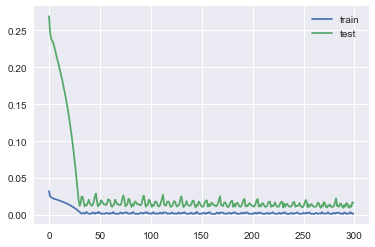

In [725]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

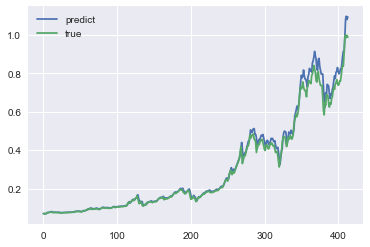

In [726]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [727]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

#### RMSE

In [728]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 160.999


#### Plot line graph with Y as USD

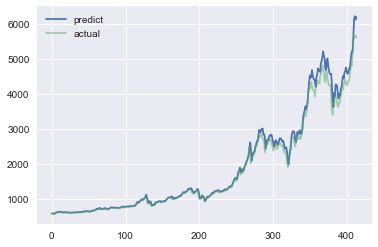

In [729]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Convert X to dates

In [730]:
predictDates = data.tail(len(testX)).index

#### Reshape testY and yhat for plotly

In [731]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [732]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

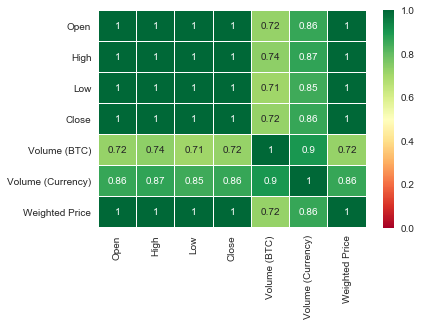

In [733]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`. 
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`

#### Function to convert series to supervised learning

In [734]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Get all data values

In [735]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')

#### Normalize features to range from 0 to 1

In [736]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Frame as supervised learning

In [737]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.116909,0.000715,0.000177,0.116422,0.000878,0.000216
2,0.116422,0.000878,0.000216,0.115041,0.000373,0.000091
3,0.115041,0.000373,0.000091,0.117474,0.000367,0.000091
4,0.117474,0.000367,0.000091,0.125800,0.000858,0.000225
5,0.125800,0.000858,0.000225,0.120299,0.001164,0.000294


#### Drop columns `Open`, `High`, `Low`, `Close`

In [738]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.116909   0.000715   0.000177  0.116422
2   0.116422   0.000878   0.000216  0.115041
3   0.115041   0.000373   0.000091  0.117474
4   0.117474   0.000367   0.000091  0.125800
5   0.125800   0.000858   0.000225  0.120299


#### Split data to 70% training, 30% testing

In [739]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((965, 1, 3), (965,), (414, 1, 3), (414,))


#### Training the LSTM model with 300 epochs

In [740]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 965 samples, validate on 414 samples
Epoch 1/300
3s - loss: 0.0320 - val_loss: 0.2620
Epoch 2/300
0s - loss: 0.0246 - val_loss: 0.2363
Epoch 3/300
0s - loss: 0.0239 - val_loss: 0.2231
Epoch 4/300
0s - loss: 0.0225 - val_loss: 0.2180
Epoch 5/300
0s - loss: 0.0216 - val_loss: 0.2126
Epoch 6/300
0s - loss: 0.0209 - val_loss: 0.2036
Epoch 7/300
0s - loss: 0.0207 - val_loss: 0.1937
Epoch 8/300
0s - loss: 0.0200 - val_loss: 0.1867
Epoch 9/300
0s - loss: 0.0194 - val_loss: 0.1784
Epoch 10/300
0s - loss: 0.0191 - val_loss: 0.1693
Epoch 11/300
0s - loss: 0.0184 - val_loss: 0.1611
Epoch 12/300
0s - loss: 0.0180 - val_loss: 0.1526
Epoch 13/300
0s - loss: 0.0173 - val_loss: 0.1444
Epoch 14/300
0s - loss: 0.0169 - val_loss: 0.1342
Epoch 15/300
0s - loss: 0.0164 - val_loss: 0.1250
Epoch 16/300
0s - loss: 0.0158 - val_loss: 0.1183
Epoch 17/300
0s - loss: 0.0152 - val_loss: 0.1117
Epoch 18/300
0s - loss: 0.0147 - val_loss: 0.1044
Epoch 19/300
0s - loss: 0.0141 - val_loss: 0.0966
Epoch 20/300


0s - loss: 0.0032 - val_loss: 0.0118
Epoch 165/300
0s - loss: 0.0019 - val_loss: 0.0184
Epoch 166/300
0s - loss: 0.0018 - val_loss: 0.0205
Epoch 167/300
0s - loss: 0.0030 - val_loss: 0.0205
Epoch 168/300
0s - loss: 0.0024 - val_loss: 0.0119
Epoch 169/300
0s - loss: 0.0039 - val_loss: 0.0142
Epoch 170/300
0s - loss: 0.0032 - val_loss: 0.0116
Epoch 171/300
0s - loss: 0.0018 - val_loss: 0.0172
Epoch 172/300
0s - loss: 0.0017 - val_loss: 0.0174
Epoch 173/300
0s - loss: 0.0024 - val_loss: 0.0154
Epoch 174/300
0s - loss: 0.0021 - val_loss: 0.0110
Epoch 175/300
0s - loss: 0.0034 - val_loss: 0.0132
Epoch 176/300
0s - loss: 0.0033 - val_loss: 0.0114
Epoch 177/300
0s - loss: 0.0020 - val_loss: 0.0168
Epoch 178/300
0s - loss: 0.0018 - val_loss: 0.0189
Epoch 179/300
0s - loss: 0.0029 - val_loss: 0.0186
Epoch 180/300
0s - loss: 0.0023 - val_loss: 0.0112
Epoch 181/300
0s - loss: 0.0040 - val_loss: 0.0149
Epoch 182/300
0s - loss: 0.0032 - val_loss: 0.0111
Epoch 183/300
0s - loss: 0.0018 - val_loss: 0

#### Plot line graph to show amount loss according the the epoch

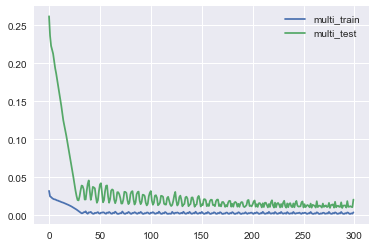

In [741]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

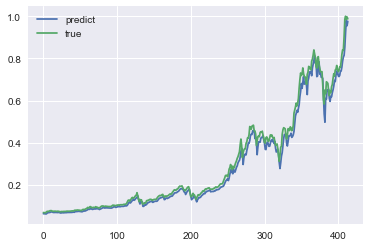

In [742]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [743]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#### RMSE

In [744]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 158.377


#### Plot line graph with actual price, predicted price with feature `Weighted Price`, predicted price with features `Volume` and `Weighted Price`

In [745]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

- LSTM with single feature of `Weighted Price` have RMSE of 160.999
- LSTM with features of `Volume(BTC)`, `Volume(Currency)` and `Weighted Price` have RMSE of 158.377
- LSTM with multi features shows more accurate results as show in line chart above